# chengshuai — HFO 群体事件可视化

## 架构原则（2026-01-16 重构）

> **本 notebook 只负责读取中间结果并可视化，不做任何复杂计算。**

**数据流**：
```
*_groupAnalysis.npz (质心/TF质心/lag/rank)
*_envCache.npz (envelope + 带通信号)       →  本Notebook (只读取+画图)  →  matplotlib
*_packedTimes.npy (事件窗口)
```

**可视化内容**：
1. Fig1：带通波形 raster（拼接事件窗口）
2. Fig2：TF 功率背景 + 质心点 + 传播路径
3. 热图：channels × events 的 energy/rank/lag
4. 统计：lag 分布、TF 质心分布、通道参与率

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import importlib

sys.path.insert(0, '/home/honglab/leijiaxin/HFOsp/')

# Visualization-only imports (读取中间结果 + 画图)
from src.group_event_analysis import (
    load_group_analysis_results,
    load_envelope_cache,
    compute_and_save_group_analysis,
    compute_and_save_hfo_event_wavelet_tfr,
    compute_and_save_hfo_event_wavelet_tfr_two_bands,
)
from src.preprocessing import save_raw_cache, load_raw_cache
import src.visualization as visualization
importlib.reload(visualization)
from src.visualization import (
    plot_paper_fig1_bandpassed_traces,
    plot_paper_fig2_normalized_spectrogram,
    plot_lag_heatmaps_from_group_analysis,
    plot_lag_statistics,
    plot_tf_centroid_statistics,
    plot_bandpassed_segment_from_cache,
    plot_channel_waveform_and_envelope_from_cache,
    build_event_spans_from_packed_times,
    plot_channel_lag_distributions,
    plot_channel_centroid_distributions,
    plot_raw_segment_from_cache,
    plot_hfo_event_verification_from_tfr_cache,
)

# Basic visualization settings
BASIC_START_SEC = 0.0
BASIC_DURATION_SEC = 10.0
SHAFT = 'K'
CHANNEL_LIST = ['K1-K2', 'K2-K3', 'K3-K4']
SINGLE_CHANNEL = 'K3-K4'
USE_RAW = True

# Configuration
PATIENT = 'chengshuai'
RECORD = 'FC10477Q'
DATA_ROOT = Path('/mnt/yuquan_data/yuquan_24h_edf')

EDF_PATH = DATA_ROOT / PATIENT / f'{RECORD}.edf'
GPU_NPZ = DATA_ROOT / PATIENT / f'{RECORD}_gpu.npz'
PACKED_TIMES = DATA_ROOT / PATIENT / f'{RECORD}_packedTimes.npy'
LAGPAT_NPZ = DATA_ROOT / PATIENT / f'{RECORD}_lagPat.npz'
GROUP_ANALYSIS_PATH = DATA_ROOT / PATIENT / f'{RECORD}_groupAnalysis.npz'
ENV_CACHE_PATH = DATA_ROOT / PATIENT / f'{RECORD}_envCache_ripple_bipolar.npz'
RAW_CACHE_PATH = DATA_ROOT / PATIENT / f'{RECORD}_rawCache_none.npz'

# Visualization settings
EVENT_INDICES = list(range(30))  # First 30 events

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

/home/honglab/leijiaxin/anaconda3/envs/cuda_env/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


## 1. 检查/生成中间结果

如果 `*_groupAnalysis.npz` 和 `*_envCache.npz` 不存在，则调用 `compute_and_save_group_analysis()` 生成。

In [2]:
print('=== 检查中间结果 ===')
print(f'Group analysis exists: {GROUP_ANALYSIS_PATH.exists()}')
print(f'Env cache exists: {ENV_CACHE_PATH.exists()}')
print(f'Raw cache exists: {RAW_CACHE_PATH.exists()}')

if not GROUP_ANALYSIS_PATH.exists() or not ENV_CACHE_PATH.exists():
    print('\n生成中间结果...')
    out_paths = compute_and_save_group_analysis(
        edf_path=str(EDF_PATH),
        output_dir=str(DATA_ROOT / PATIENT),
        output_prefix=RECORD,
        packed_times_path=str(PACKED_TIMES),
        gpu_npz_path=str(GPU_NPZ),
        band='ripple',
        reference='bipolar',
        alias_bipolar_to_left=True,
        crop_seconds=120.0,
        use_gpu=True,
        save_env_cache=True,
    )
    print('✓ 生成完成')
else:
    print('✓ 中间结果已存在，跳过生成')

if USE_RAW and not RAW_CACHE_PATH.exists():
    print('\n生成 rawCache (no filter/resample)...')
    raw_path = save_raw_cache(
        edf_path=str(EDF_PATH),
        output_dir=str(DATA_ROOT / PATIENT),
        output_prefix=RECORD,
        reference='none',
        crop_seconds=120.0,
    )
    print(f'✓ rawCache created: {raw_path}')
elif USE_RAW:
    print('✓ rawCache 已存在，跳过生成')

=== 检查中间结果 ===
Group analysis exists: True
Env cache exists: True
Raw cache exists: True
✓ 中间结果已存在，跳过生成
✓ rawCache 已存在，跳过生成


## 2. 加载中间结果

加载预计算的 group analysis 结果和 envelope cache。

In [3]:
# Load pre-computed group analysis results
ga = load_group_analysis_results(str(GROUP_ANALYSIS_PATH))
cache = load_envelope_cache(str(ENV_CACHE_PATH))

print('=== Group Analysis ===')  
print(f'  n_channels: {ga["n_channels"]}')
print(f'  n_events: {ga["n_events"]}')
print(f'  band: {ga["band"]}')
print(f'  sfreq: {ga["sfreq"]} Hz')

print('\n=== Envelope Cache ===')
print(f'  env shape: {cache["env"].shape}')
print(f'  x_band available: {cache["x_band"] is not None}')

# Load core channels from lagPat reference
lag_ref = np.load(LAGPAT_NPZ, allow_pickle=True)
CORE_CHANNELS = [str(x) for x in lag_ref['chnNames'].tolist()]
print(f'\n=== Core Channels (n={len(CORE_CHANNELS)}) ===')
print(f'  {CORE_CHANNELS[:10]}...')

=== Group Analysis ===
  n_channels: 110
  n_events: 44
  band: ripple
  sfreq: 1000.0 Hz

=== Envelope Cache ===
  env shape: (110, 120001)
  x_band available: True

=== Core Channels (n=8) ===
  ['E11', 'K3', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10']...


## 3. 基础可视化：全通道 / 电极 / 通道列表

基于 `*_envCache.npz` 的带通波形与 envelope，并用群体事件窗口进行红色 shading。

## 3.1 HFO 事件双域验证卡片（Wavelet TFR）

> 目标：用一张图同时回答两个问题：
> 1) **时域**：原始宽带 LFP 是否出现短暂高频振荡？（红色窗口为事件）
> 2) **频域**：Wavelet 时频图中是否出现 Ripple 段（>80Hz）局限性的高能“孤岛”（spectral blob）？

**注意**：Wavelet TFR 是预计算并保存的（`compute_and_save_hfo_event_wavelet_tfr`），本节只负责读取缓存并绘图（`plot_hfo_event_verification_from_tfr_cache`）。


[HFO-verify] use raw channel 'K3' instead of 'K3-K4'
TFR artifacts: {'ripple': '/mnt/yuquan_data/yuquan_24h_edf/chengshuai/FC10477Q_hfoVerify_wavelet_ripple_K3_0p342_0p842.npz', 'fast_ripple': '/mnt/yuquan_data/yuquan_24h_edf/chengshuai/FC10477Q_hfoVerify_wavelet_fast_ripple_K3_0p342_0p842.npz'}


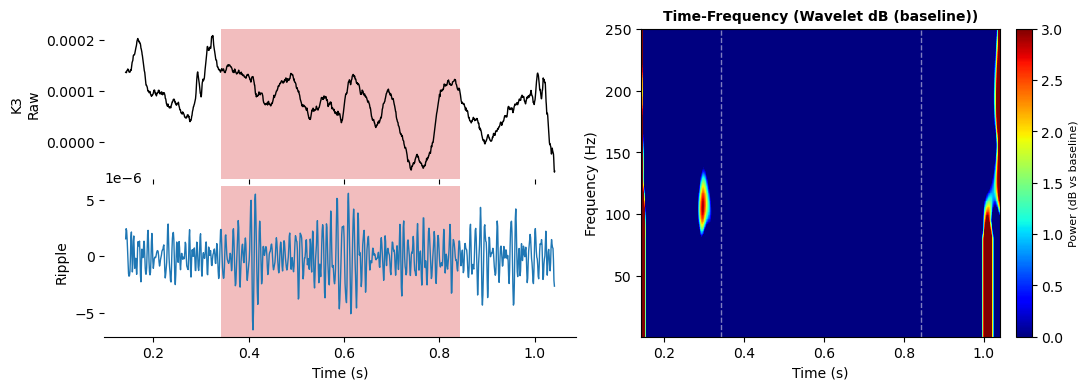

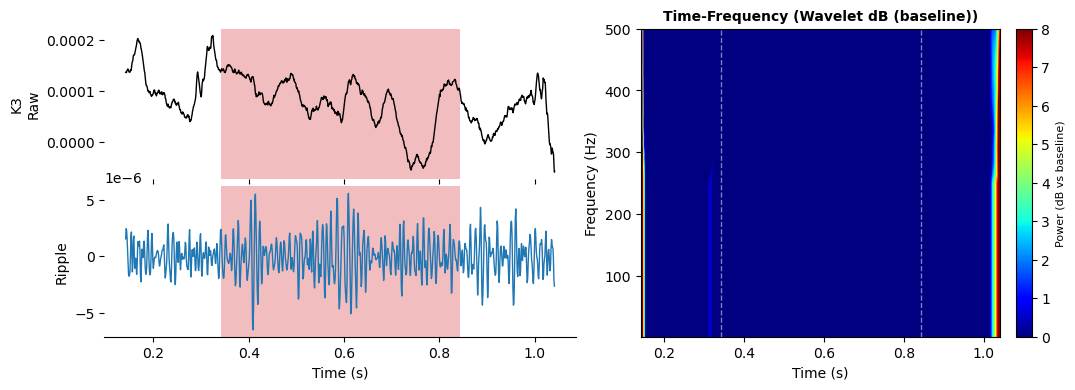

In [13]:
# Pick one group-event window from packedTimes (absolute seconds)
packed = np.load(PACKED_TIMES, allow_pickle=True)
ev_idx = 0
EV_START, EV_END = float(packed[ev_idx, 0]), float(packed[ev_idx, 1])

# Choose a channel (prefer one you care about)
TARGET_CH = SINGLE_CHANNEL

# Raw cache may be monopolar (e.g., 'K3') even if SINGLE_CHANNEL is bipolar ('K3-K4').
# Auto-fix to a valid raw channel name.
raw_cache = load_raw_cache(str(RAW_CACHE_PATH))
raw_ch_names = [str(x) for x in raw_cache["ch_names"]]
if TARGET_CH not in raw_ch_names:
    if "-" in TARGET_CH:
        cand = TARGET_CH.split("-", 1)[0].strip()
        if cand in raw_ch_names:
            print(f"[HFO-verify] use raw channel '{cand}' instead of '{TARGET_CH}'")
            TARGET_CH = cand
if TARGET_CH not in raw_ch_names:
    raise ValueError(f"Target channel '{TARGET_CH}' not found in raw cache. Example channels: {raw_ch_names[:10]}")

# Precompute wavelet TFR artifacts for BOTH bands (saved next to raw cache by default)
tfr_paths = compute_and_save_hfo_event_wavelet_tfr_two_bands(
    raw_cache_npz_path=str(RAW_CACHE_PATH),
    target_channel=TARGET_CH,
    event_start=EV_START,
    event_end=EV_END,
    margin_sec=0.2,
    n_freqs=180,
    n_cycles_ripple=4.0,
    n_cycles_fast_ripple=4.0,
    n_cycles_mode="linear",
    n_cycles_min=3.0,
    n_cycles_max=10.0,
    decim=2,
    baseline_mode="none",  # baseline handled in visualization
    smooth_time_ms=10.0,
    smooth_freq_bins=2.0,
    overwrite=False,
)
print('TFR artifacts:', tfr_paths)

# Plot ripple band (80-250 Hz)
fig_verify_rp = plot_hfo_event_verification_from_tfr_cache(
    raw_cache_npz_path=str(RAW_CACHE_PATH),
    env_cache_npz_path=str(ENV_CACHE_PATH),
    tfr_npz_path=str(tfr_paths['ripple']),
    cmap_tf='jet',
    figsize=(12, 4),
    tf_map='db_ratio_smooth',
    baseline_window_sec=(0.2, 0.1),
    tf_vmin=0.0,
    tf_vmax=3.0,
)
plt.show()

# Plot fast-ripple band (250-500 Hz)
fig_verify_fr = plot_hfo_event_verification_from_tfr_cache(
    raw_cache_npz_path=str(RAW_CACHE_PATH),
    env_cache_npz_path=str(ENV_CACHE_PATH),
    tfr_npz_path=str(tfr_paths['fast_ripple']),
    cmap_tf='jet',
    figsize=(12, 4),
    tf_map='db_ratio_smooth',
    baseline_window_sec=(0.5, 0.45),
    tf_vmin=0.0,
    tf_vmax=8.0,
)
plt.show()


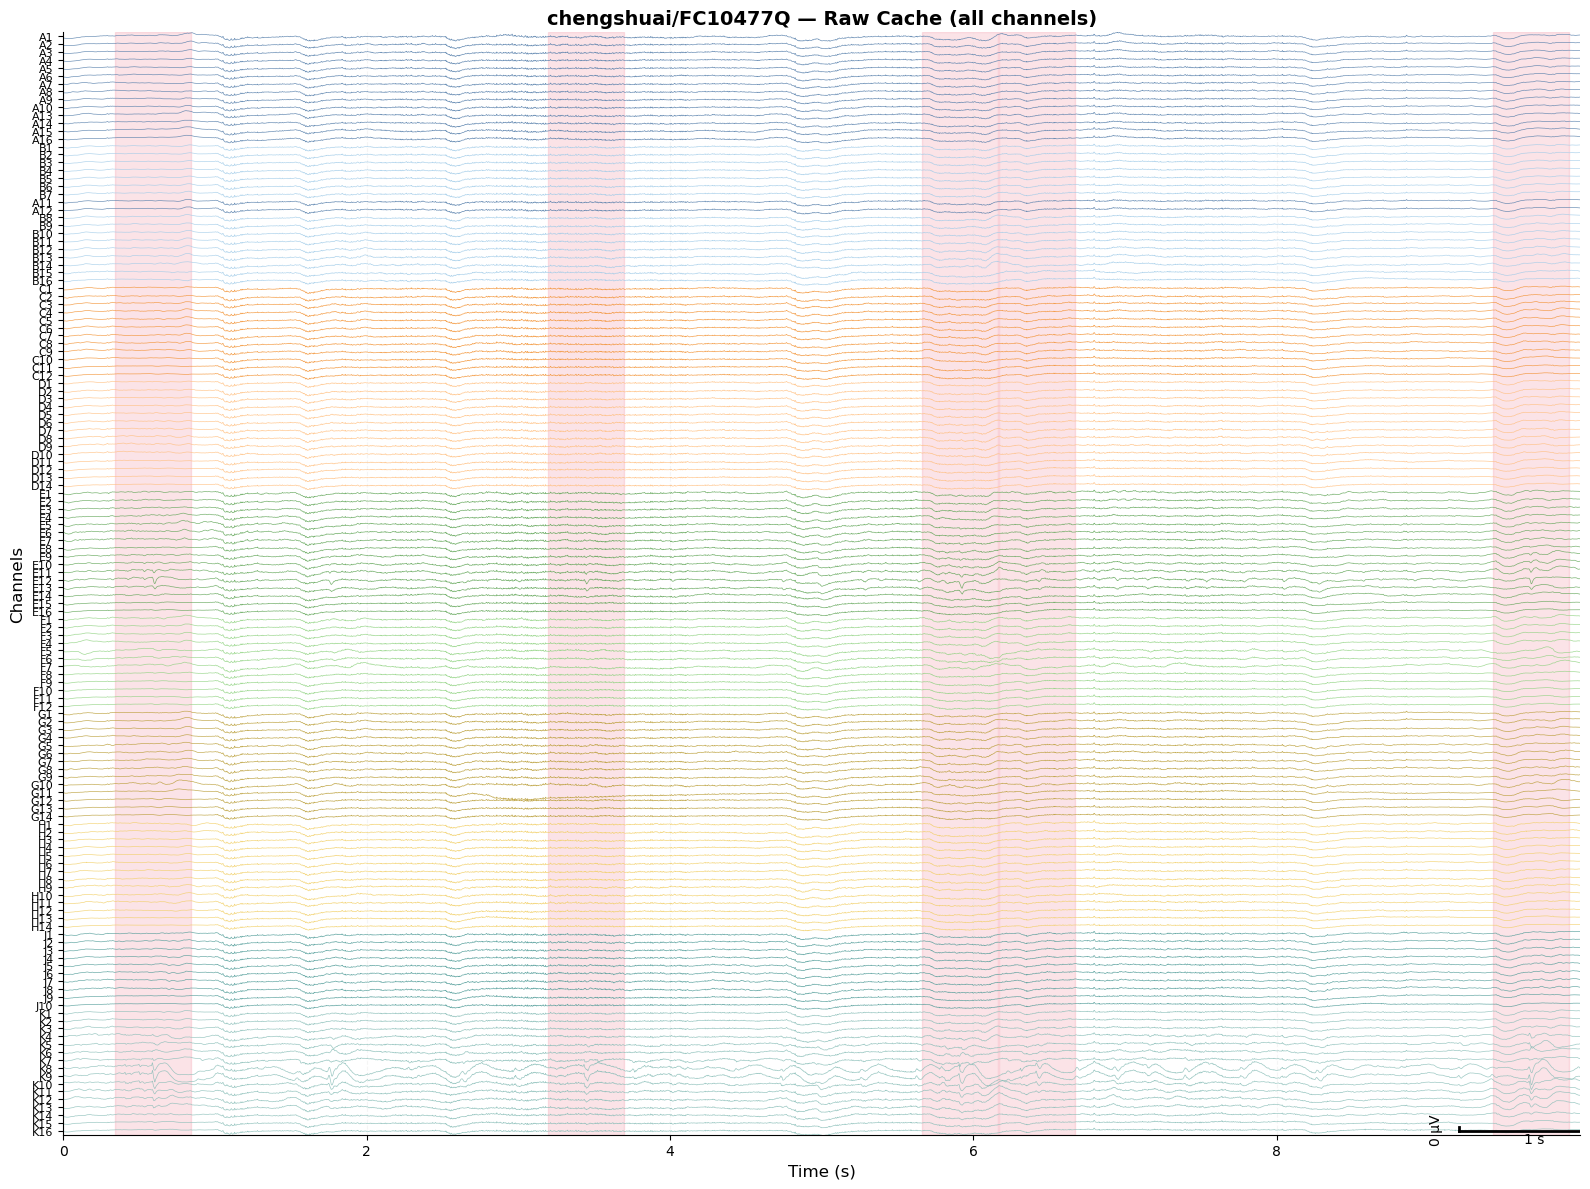

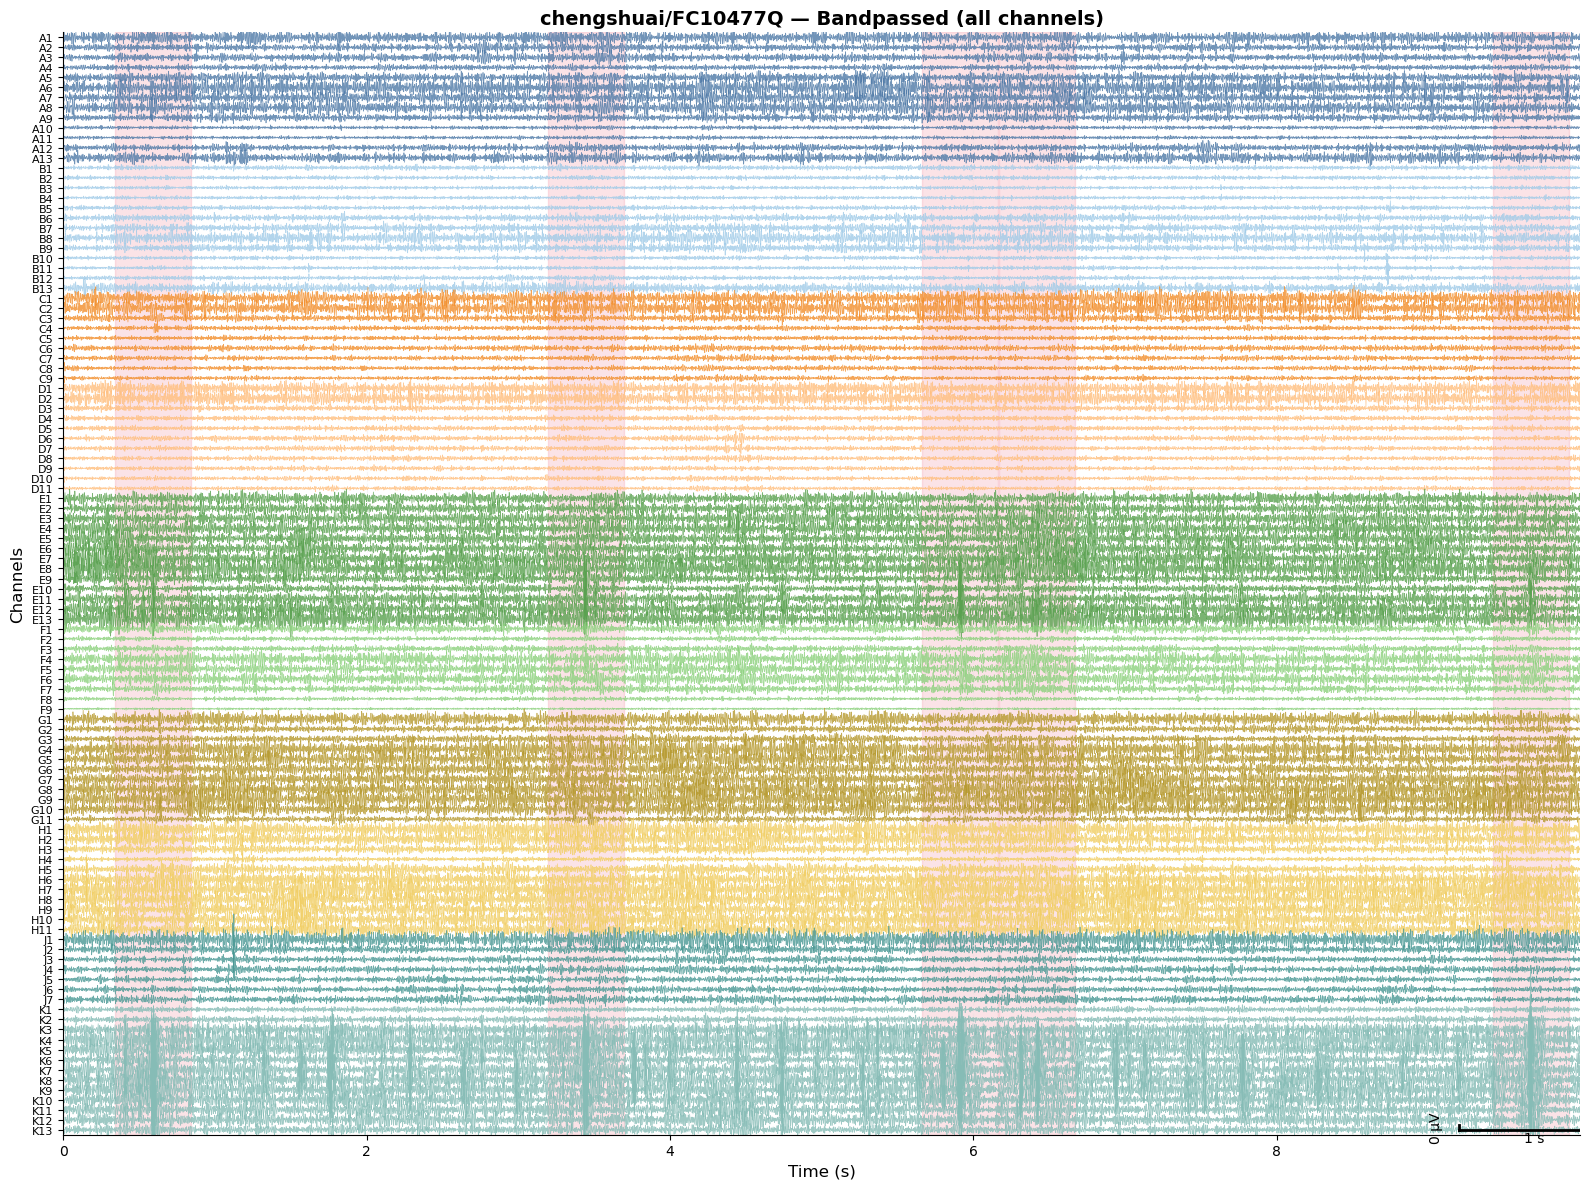

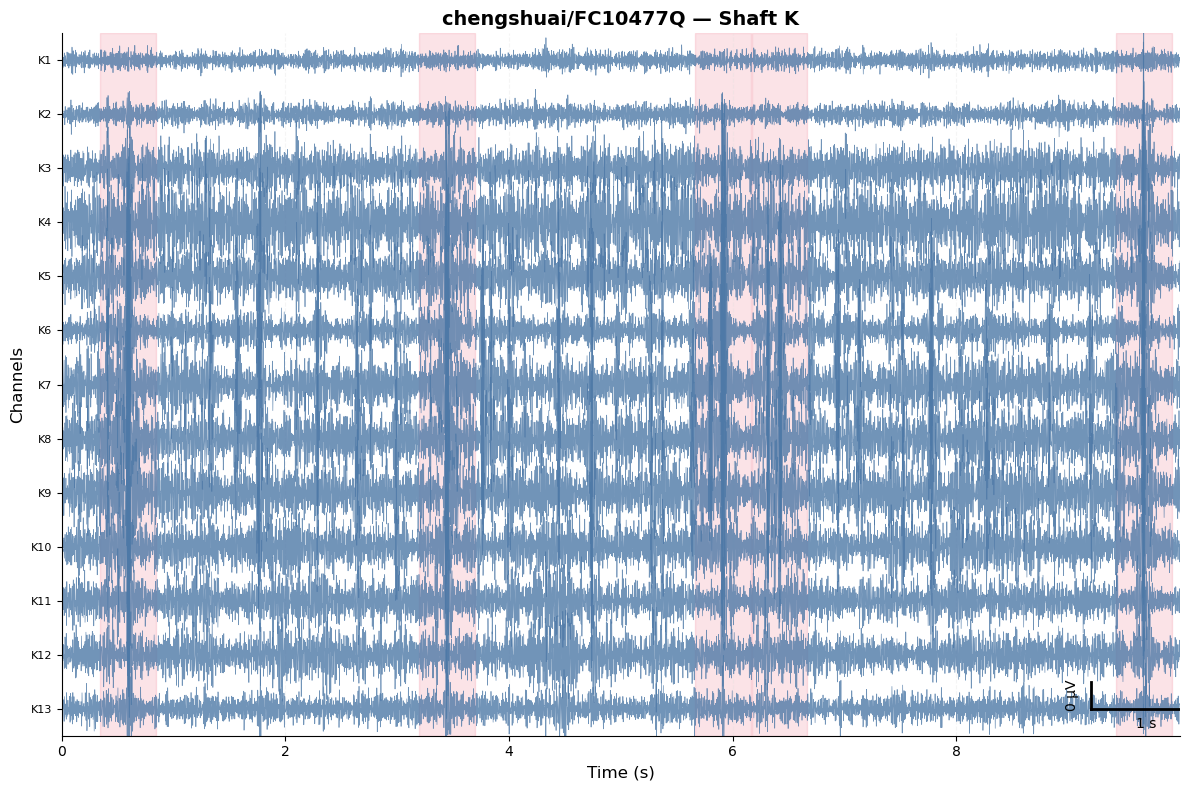

ValueError: No channels selected for plotting

In [14]:
# Build event spans for shading
event_spans = build_event_spans_from_packed_times(
    str(PACKED_TIMES),
    start_sec=BASIC_START_SEC,
    end_sec=BASIC_START_SEC + BASIC_DURATION_SEC,
    max_events=200,
    color="#e94560",
    alpha=0.15,
)

# 3.2 Raw Cache 全通道波形 (来自 preprocessing.py)
if USE_RAW:
    fig_raw = plot_raw_segment_from_cache(
        raw_cache_npz_path=str(RAW_CACHE_PATH),
        packed_times_path=str(PACKED_TIMES),
        start_sec=BASIC_START_SEC,
        duration_sec=BASIC_DURATION_SEC,
        channels='all',
        color_by_shaft=True,
        event_alpha=0.15,
        max_events=200,
        figsize=(16, 12),
        title=f"{PATIENT}/{RECORD} — Raw Cache (all channels)",
    )
    plt.show()

# 3.3 全通道带通波形 (stacked)
fig_all = plot_bandpassed_segment_from_cache(
    cache_npz_path=str(ENV_CACHE_PATH),
    packed_times_path=str(PACKED_TIMES),
    start_sec=BASIC_START_SEC,
    duration_sec=BASIC_DURATION_SEC,
    channels='all',
    mode='bandpassed',
    color_by_shaft=True,
    event_alpha=0.15,
    max_events=200,
    figsize=(16, 12),
    title=f"{PATIENT}/{RECORD} — Bandpassed (all channels)",
)
plt.show()

# 3.4 单电极串 (shaft) 带通波形
fig_shaft = plot_bandpassed_segment_from_cache(
    cache_npz_path=str(ENV_CACHE_PATH),
    packed_times_path=str(PACKED_TIMES),
    start_sec=BASIC_START_SEC,
    duration_sec=BASIC_DURATION_SEC,
    channels=[ch for ch in cache['ch_names'] if str(ch).startswith(SHAFT)],
    mode='bandpassed',
    color_by_shaft=True,
    event_alpha=0.15,
    max_events=200,
    figsize=(12, 8),
    title=f"{PATIENT}/{RECORD} — Shaft {SHAFT}",
)
plt.show()

# 3.5 指定通道列表
fig_list = plot_bandpassed_segment_from_cache(
    cache_npz_path=str(ENV_CACHE_PATH),
    packed_times_path=str(PACKED_TIMES),
    start_sec=BASIC_START_SEC,
    duration_sec=BASIC_DURATION_SEC,
    channels=CHANNEL_LIST,
    mode='bandpassed',
    color_by_shaft=True,
    event_alpha=0.15,
    max_events=200,
    figsize=(12, 6),
    title=f"{PATIENT}/{RECORD} — Selected channels",
)
plt.show()

# 3.6 单通道：波形 vs Envelope（左右对照）
# fig_we = plot_channel_waveform_and_envelope_from_cache(
#     cache_npz_path=str(ENV_CACHE_PATH),
#     packed_times_path=str(PACKED_TIMES),
#     channel=SINGLE_CHANNEL,
#     start_sec=BASIC_START_SEC,
#     duration_sec=2.0,
#     event_alpha=0.2,
#     max_events=200,
#     figsize=(12, 4),
# )
# plt.show()

## 4. Fig1: 带通波形 Raster

显示拼接的事件窗口中的 80-250Hz 带通波形。

In [ ]:
fig1 = plot_paper_fig1_bandpassed_traces(
    cache_npz_path=str(ENV_CACHE_PATH),
    packed_times_path=str(PACKED_TIMES),
    channel_order=CORE_CHANNELS,
    event_indices=EVENT_INDICES,
    max_events=len(EVENT_INDICES),
    figsize=(16, 10),
)
plt.suptitle(f"{PATIENT}/{RECORD} — Bandpassed Traces (80-250Hz)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. Fig2: TF 功率 + 质心路径

STFT 归一化功率背景 + 每事件的 TF 质心点 + 传播路径。

**注意**：现在从 `*_groupAnalysis.npz` 读取预计算的 TF 质心，不再内部计算。

/tmp/ipykernel_1421299/3420251075.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


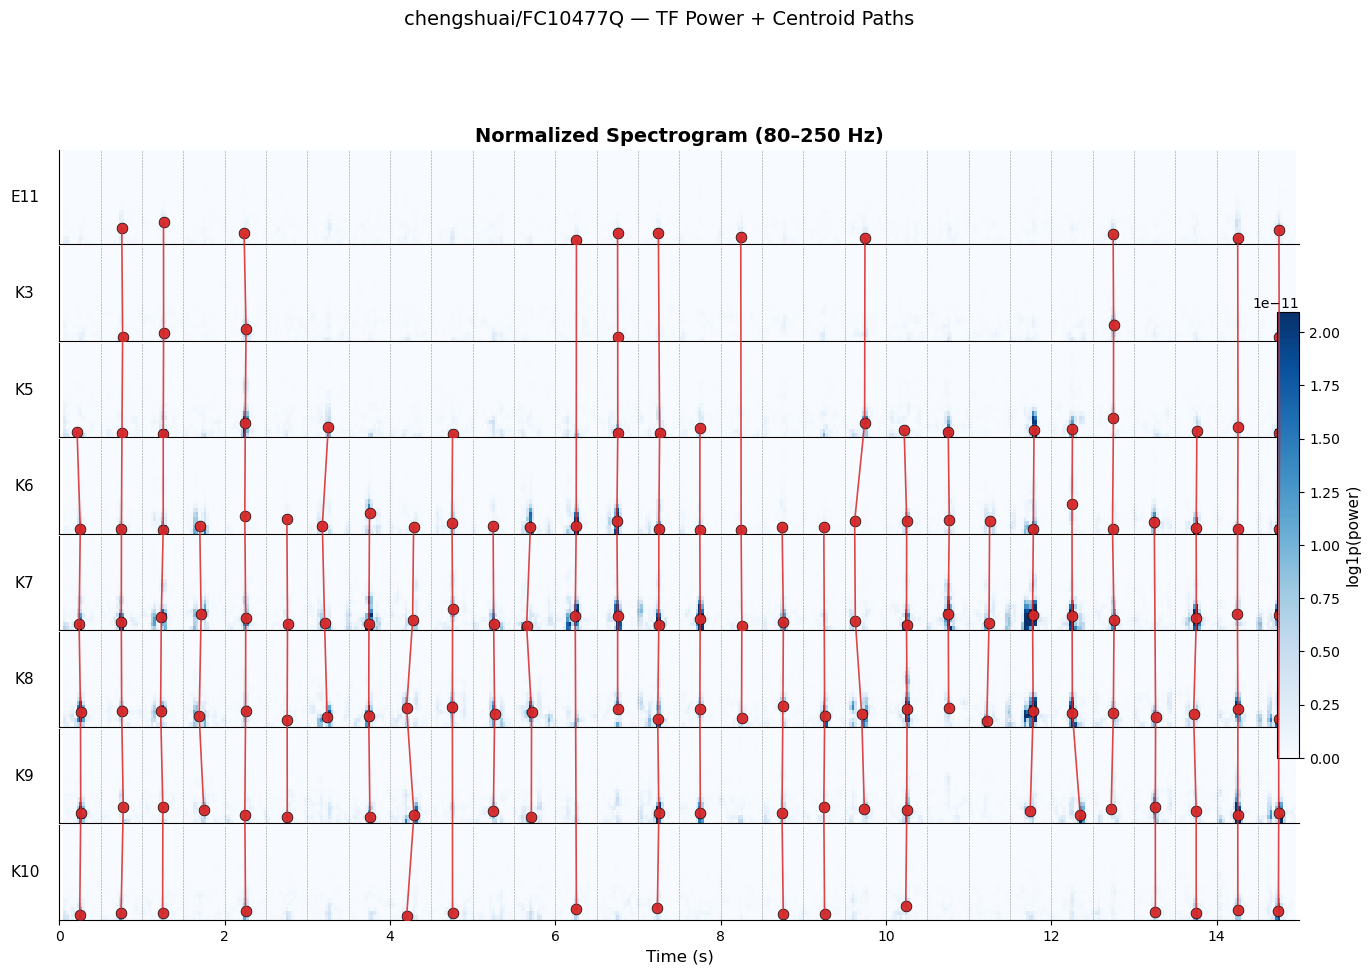

In [15]:
fig2 = plot_paper_fig2_normalized_spectrogram(
    cache_npz_path=str(ENV_CACHE_PATH),
    packed_times_path=str(PACKED_TIMES),
    detections_npz_path=str(GPU_NPZ),
    group_analysis_npz_path=str(GROUP_ANALYSIS_PATH),
    channel_order=CORE_CHANNELS,
    event_indices=EVENT_INDICES,
    max_events=len(EVENT_INDICES),
    freq_band=(80.0, 250.0),
    centroid_marker_size=60.0,
    figsize=(16, 10),
)
plt.suptitle(f"{PATIENT}/{RECORD} — TF Power + Centroid Paths", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. 热图：Energy / Rank / Lag

直接从 `*_groupAnalysis.npz` 读取预计算的结果。

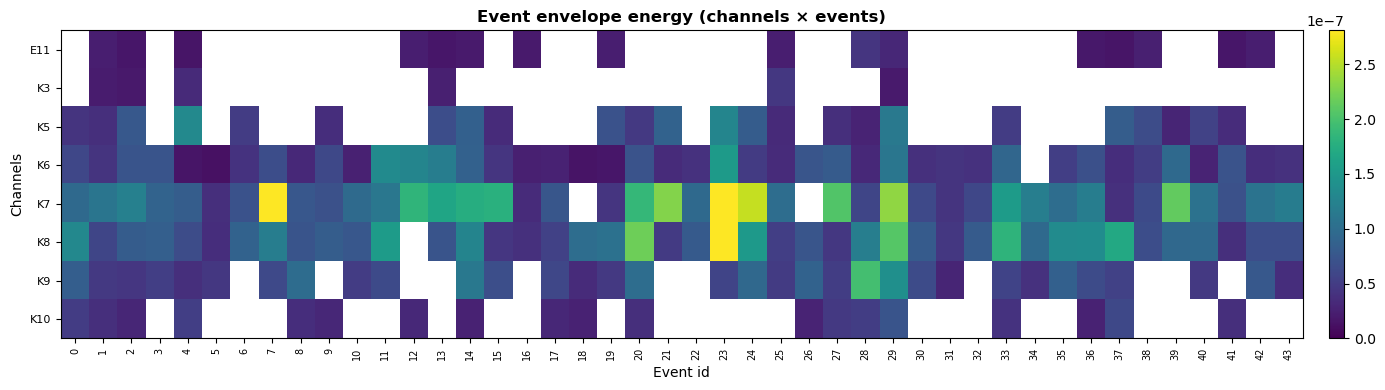

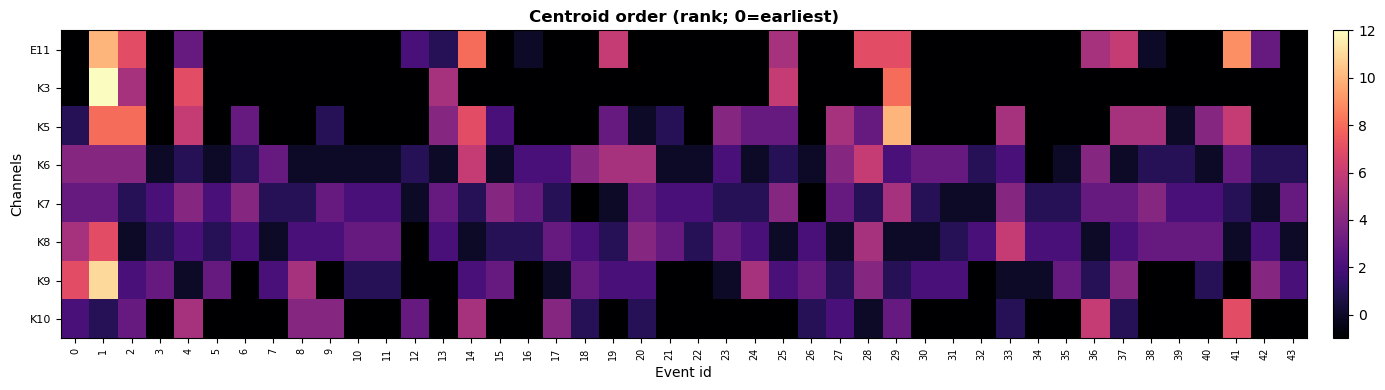

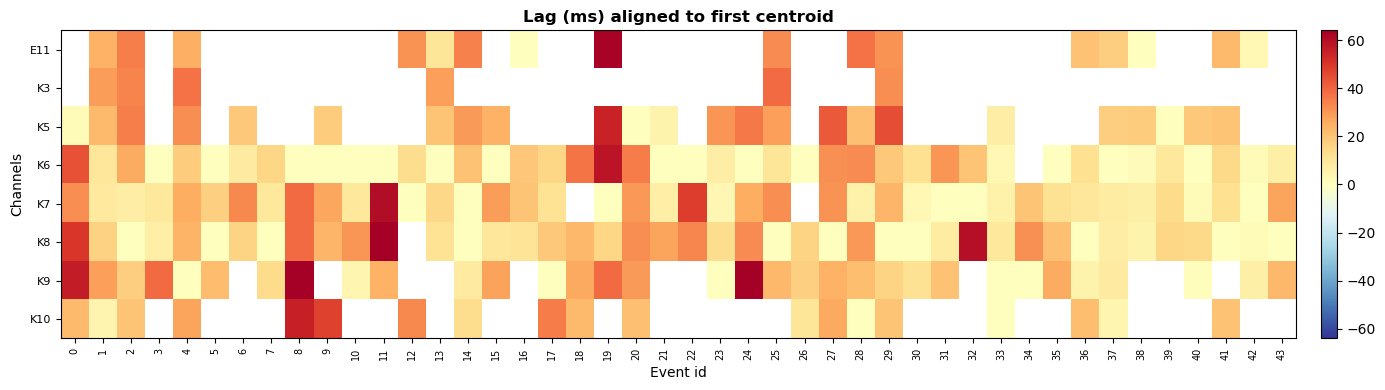

In [16]:
figE, figR, figL = plot_lag_heatmaps_from_group_analysis(
    group_analysis_npz=str(GROUP_ANALYSIS_PATH),
    env_cache_npz=str(ENV_CACHE_PATH),
    packed_times_npy=str(PACKED_TIMES),
    channel_names=CORE_CHANNELS,
    max_events=100,
    figsize=(14, 4),
)
plt.show()


## 7. 统计分析：Lag / Rank / Participation

从 `*_groupAnalysis.npz` 读取预计算结果进行统计。

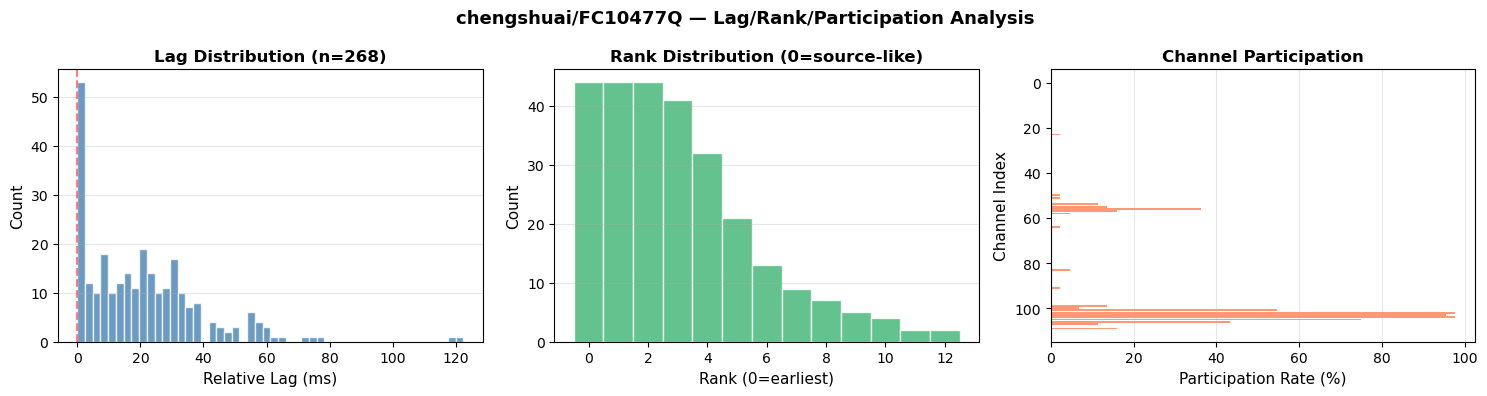

In [17]:
fig_stats = plot_lag_statistics(
    group_analysis_npz=str(GROUP_ANALYSIS_PATH),
    patient_id=PATIENT,
    record_id=RECORD,
    figsize=(15, 4),
)
plt.show()


## 8. 每通道 Lag/质心 分布（自上而下）

参考图示：每个通道一条分布，红线连接每通道的质心。

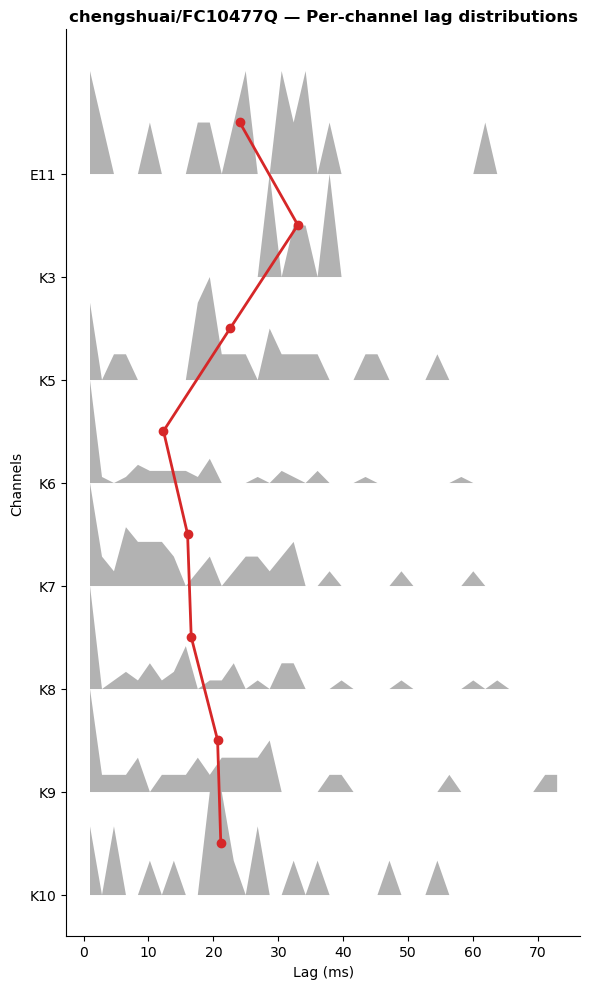

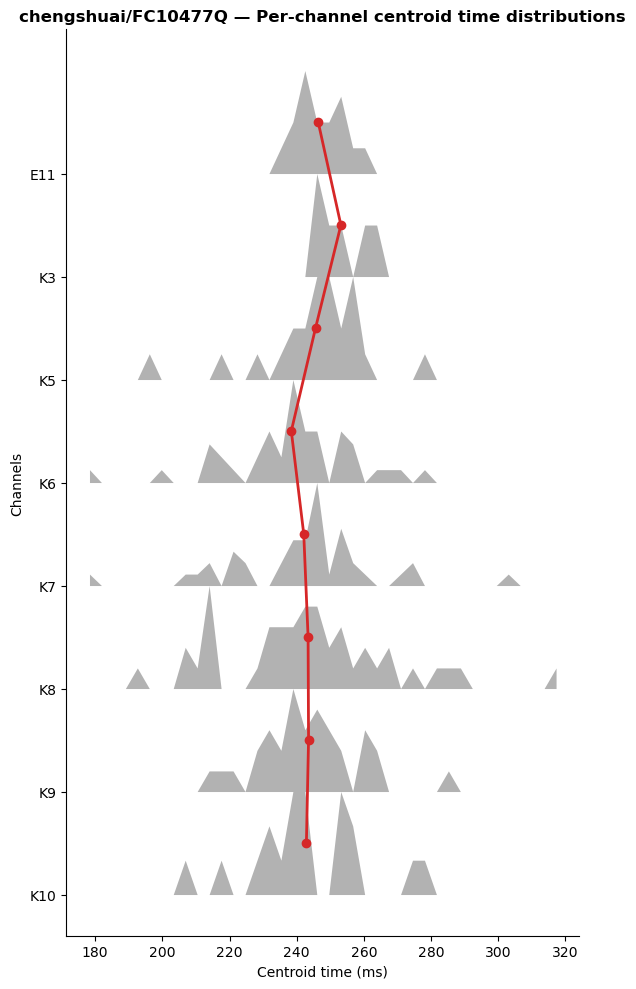

In [18]:
fig_lag_ridge = plot_channel_lag_distributions(
    group_analysis_npz=str(GROUP_ANALYSIS_PATH),
    channel_order=CORE_CHANNELS,
    bins=40,
    figsize=(6, 10),
    title=f"{PATIENT}/{RECORD} — Per-channel lag distributions",
)
plt.show()

fig_centroid_ridge = plot_channel_centroid_distributions(
    group_analysis_npz=str(GROUP_ANALYSIS_PATH),
    channel_order=CORE_CHANNELS,
    bins=40,
    figsize=(6, 10),
    title=f"{PATIENT}/{RECORD} — Per-channel centroid time distributions",
)
plt.show()

## 9. TF 质心统计

从 `*_groupAnalysis.npz` 读取预计算的 TF 质心结果。

In [ ]:
fig_tf = plot_tf_centroid_statistics(
    group_analysis_npz=str(GROUP_ANALYSIS_PATH),
    patient_id=PATIENT,
    record_id=RECORD,
    figsize=(12, 4),
)
if fig_tf is not None:
    plt.show()
else:
    print('TF centroids not available in groupAnalysis results')


---

## 附录：切换患者/记录

只需修改 Cell 1 中的 `PATIENT`/`RECORD` 配置，重新运行即可。

所有可视化函数都从 `src/visualization.py` 调用，不做任何复杂计算。